In [1]:
!head -10 ml-100k/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [2]:
import pandas as pd
#ratings = pd.read_csv('ml-1m/ratings.dat', delimiter="::", engine="python", header=None)
ratings = pd.read_csv('ml-100k/u.data', delimiter="\t", engine="python", header=None)

In [3]:
ratings.columns = ["UserID::MovieID::Rating::Timestamp".split("::")]
#ratings = ratings.iloc[:1000, :]
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
ratings.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [5]:
import numpy as np
np.unique(ratings['Rating'])

array([1, 2, 3, 4, 5])

* Do we have any duplicate ratings, i.e., a (userid, movieid) combination that is repeated more than once?

In [6]:
user_movie_pairs = zip(ratings['UserID'].values, ratings['MovieID'].values)

In [7]:
print len(user_movie_pairs), len(set(user_movie_pairs))

100000 100000


In [8]:
print ratings['UserID'].describe()
n_user = len(ratings['UserID'].unique())
print "number of users: %s\n" % n_user
print set(ratings['UserID'].unique()) == set(range(1, n_user + 1))
# User ids are range(1, 6041), i.e., are all values between 1 and 6040
# We can use a simple mapping: user_index=UserID-1

count    100000.00000
mean        462.48475
std         266.61442
min           1.00000
25%         254.00000
50%         447.00000
75%         682.00000
max         943.00000
Name: UserID, dtype: float64
number of users: 943

True


In [9]:
!cat ml-100k/u.info

943 users
1682 items
100000 ratings


In [10]:
#!head ml-1m/movies.dat
!head ml-100k/u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0
7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0
8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|0|0|0|1

In [11]:
#movies = pd.read_csv('ml-1m/movies.dat', delimiter='::', engine='python', header=None)
movies = pd.read_csv('ml-100k/u.item', delimiter='|', engine='python', header=None)
#movies.columns = 'MovieID::Title::Genres'.split('::')
columns = ' MovieID | movie title | release date | video release date |' \
              'IMDb URL | unknown | Action | Adventure | Animation |'\
              'Children | Comedy | Crime | Documentary | Drama | Fantasy |'\
              'Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |'\
              'Thriller | War | Western'.split('|')

movies.columns = ["-".join(i.strip().split()) for i in columns]                
movies.head()

print "The following movie id's are missing from movie table"
print sorted(set(range(1, movies.MovieID.max())) - set(movies.MovieID))
print "\nnumber of unique movies: %s\n" %  len(set(movies.MovieID))

mi = ratings['MovieID'].unique()
mi.sort()
print sorted(set(movies.MovieID) - set(mi))
print len(mi)
# movie id have some missing values in addition to the missing values above
# , i.e., there are movies that are not rated by any user.

#movie_index_to_ID = dict(zip(range(movies.MovieID.unique().shape[0]), movies.MovieID))
movie_index_to_ID = dict(zip(range(len(mi)), mi))
#movie_ID_to_index = dict(zip(movies.MovieID, range(movies.MovieID.unique().shape[0])))
movie_ID_to_index = {k: v for v, k in movie_index_to_ID.iteritems()}

The following movie id's are missing from movie table
[]

number of unique movies: 1682

[]
1682


In [12]:
pp_sim.shape

NameError: name 'pp_sim' is not defined

In [13]:
len(movies.MovieID) == len(movies.MovieID.unique())

True

In [14]:
from scipy.sparse import csr_matrix
row = ratings['MovieID'].values
col = ratings['UserID'].values
data = ratings['Rating'].values
ratings_matrix = csr_matrix((data, (row, col)))

In [15]:
ratings_matrix.shape

(1683, 944)

In [16]:
def trace_dot(X, Y):
    """Trace of np.dot(X, Y.T)."""
    return np.dot(X.ravel(), Y.ravel())
norm_X = np.dot(X.data, X.data)
norm_WH = trace_dot(np.dot(np.dot(W.T, W), H), H)
cross_prod = trace_dot((X * H.T), W)
error = np.sqrt(norm_X + norm_WH - 2. * cross_prod)

NameError: name 'X' is not defined

In [17]:
error/X.shape[0]/X.shape[1]

NameError: name 'error' is not defined

In [18]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("WARN")

In [19]:
from pyspark.sql.functions import rand

def kfold_cv_generator(dataset, n_folds=3, seed = None):
    if not seed:
        seed = 0
    h = 1.0 / n_folds
    randCol = "cv_rand"
    df = dataset.select("*", rand(seed).alias(randCol)).cache()
    for i in range(n_folds):
        validateLB = i * h
        validateUB = (i + 1) * h
        condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
        validation = df.filter(condition)
        train = df.filter(~condition)
        yield train.drop(randCol), validation.drop(randCol)

In [20]:
#ratings_sp = spark.createDataFrame(ratings)

In [21]:
ratings.columns

Index([u'UserID', u'MovieID', u'Rating', u'Timestamp'], dtype='object')

In [22]:
import os
#TODO: Should use broadcast for movie_ID_to_index?
def parse_data(line):
    fields = line.split("\t")
    user_id = int(fields[0])
    movie_id = int(fields[1])
    rating = float(fields[2])
    ts = fields[3]
    return movie_ID_to_index_bc.value[movie_id], user_id - 1, rating, ts
    
movie_ID_to_index_bc = sc.broadcast(movie_ID_to_index)
#u_data_file = os.path.join("ml-1m", "ratings.dat")
u_data_file = os.path.join("ml-100k", "u.data")
ratings_rdd = sc.textFile(u_data_file).map(parse_data)#.cache().filter(lambda x: x is not None)

In [23]:
x = ratings_rdd.collect()
pd.DataFrame(x).describe()

,0,1,2
count,100000.000000,100000.00000,100000.000000
mean,424.530130,461.48475,3.529860
std,330.798356,266.61442,1.125674
min,0.000000,0.00000,1.000000
25%,174.000000,253.00000,3.000000
50%,321.000000,446.00000,4.000000
75%,630.000000,681.00000,4.000000
max,1681.000000,942.00000,5.000000


number of unique movies: 3883
number of users: 6040

In [24]:
ratings_columns = "UserID::MovieID::Rating::Timestamp".split("::")
ratings_sp = spark.createDataFrame(ratings_rdd, schema=ratings_columns)
ratings_sp.columns

['UserID', 'MovieID', 'Rating', 'Timestamp']

## Effect of the number of iterations

In [ ]:
# import numpy as np
import os
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

#u_data_file = os.path.join("ml-1m", "ratings.dat")
#ratings = sc.textFile(u_data_file).map(parse_data).cache()#.filter(lambda x: x is not None)

#ratings_train = ratings.filter(lambda x: x[3] < 8).map(lambda x: x[:-1])
#ratings_test = ratings.filter(lambda x: x[3] >= 8).map(lambda x: x[:-1])

#print("number of train points: %d" % ratings_train.count())
#print("number of test points: %d" % ratings_test.count())
kwargs = {'lambda_': 0.10826367338740546, 'rank': 10}
n_iters = np.arange(1, 20)
MSE_vs_n_iter = np.zeros(n_iters.shape)
n_folds = 3
for j, n_iter in enumerate(n_iters):
    MSE = np.zeros(n_folds)
    for i, (ratings_train, ratings_test) in enumerate(kfold_cv_generator(ratings_sp, n_folds)):

        # TODO: Remove timestamp column from the begining
        model = ALS.train(ratings_train.select(['UserID', 'MovieID', 'Rating']), iterations = n_iter, **kwargs)

        test_data = ratings_test.rdd.map(lambda r: (r[0], r[1]))
        predictions = model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
        p = predictions.collect()
        ratesAndPreds = ratings_test.rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        MSE[i] = (ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean())**.5

    MSE_vs_n_iter[j] = np.mean(MSE)
    print("Mean Squared Error = " + str(MSE_vs_n_iter))

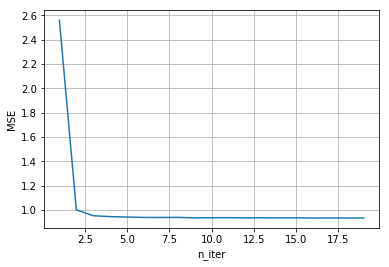

In [66]:
from matplotlib import pyplot as plt
plt.plot(n_iters, MSE_vs_n_iter)
plt.xlabel('n_iter')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

## Parameter Optimization

In [26]:

#param_map = {'rank': [1, 2, 4, 10, 20], 'lambda_': np.linspace(-3, 3, 5)}
param_map = {'a':[1, 6], 'b': [2.2, 2.5, 2.7], 'c':[3.1, 3.2, 3.3, 3.5]}

param_map.items()
value_grid = np.meshgrid(*param_map.values(), indexing='xy')
index_grid = np.meshgrid(*[range(len(i)) for i in param_map.values()], indexing='ij')
index_grids = []
for a in index_grid:
    index_grids.append(a.reshape(-1, ))

value_grids = []
for a in value_grid:
    value_grids.append(a.reshape(-1, ))

#index_grids = np.vstack(index_grids).T 
#value_grids = np.vstack(value_grids).T
print value_grids
zip(*value_grids)

[array([1, 1, 1, 6, 6, 6, 1, 1, 1, 6, 6, 6, 1, 1, 1, 6, 6, 6, 1, 1, 1, 6, 6,
       6]), array([ 3.1,  3.1,  3.1,  3.1,  3.1,  3.1,  3.2,  3.2,  3.2,  3.2,  3.2,
        3.2,  3.3,  3.3,  3.3,  3.3,  3.3,  3.3,  3.5,  3.5,  3.5,  3.5,
        3.5,  3.5]), array([ 2.2,  2.5,  2.7,  2.2,  2.5,  2.7,  2.2,  2.5,  2.7,  2.2,  2.5,
        2.7,  2.2,  2.5,  2.7,  2.2,  2.5,  2.7,  2.2,  2.5,  2.7,  2.2,
        2.5,  2.7])]


[(1, 3.1000000000000001, 2.2000000000000002),
 (1, 3.1000000000000001, 2.5),
 (1, 3.1000000000000001, 2.7000000000000002),
 (6, 3.1000000000000001, 2.2000000000000002),
 (6, 3.1000000000000001, 2.5),
 (6, 3.1000000000000001, 2.7000000000000002),
 (1, 3.2000000000000002, 2.2000000000000002),
 (1, 3.2000000000000002, 2.5),
 (1, 3.2000000000000002, 2.7000000000000002),
 (6, 3.2000000000000002, 2.2000000000000002),
 (6, 3.2000000000000002, 2.5),
 (6, 3.2000000000000002, 2.7000000000000002),
 (1, 3.2999999999999998, 2.2000000000000002),
 (1, 3.2999999999999998, 2.5),
 (1, 3.2999999999999998, 2.7000000000000002),
 (6, 3.2999999999999998, 2.2000000000000002),
 (6, 3.2999999999999998, 2.5),
 (6, 3.2999999999999998, 2.7000000000000002),
 (1, 3.5, 2.2000000000000002),
 (1, 3.5, 2.5),
 (1, 3.5, 2.7000000000000002),
 (6, 3.5, 2.2000000000000002),
 (6, 3.5, 2.5),
 (6, 3.5, 2.7000000000000002)]

In [37]:
import numpy as np
import os
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

param_map = {'rank': [1, 2, 3, 4, 5, 10], 'lambda_': np.logspace(-2, 1, 30)}

value_grid = np.meshgrid(*param_map.values(), indexing='xy')
index_grid = np.meshgrid(*[range(len(i)) for i in param_map.values()], indexing='ij')
index_grids = []
for a in index_grid:
    index_grids.append(a.reshape(-1, ))

value_grids = []
for a in value_grid:
    value_grids.append(a.reshape(-1, ))

#index_grids = np.vstack(index_grids).T 
#value_grids = np.vstack(value_grids).T
index_grids = zip(*index_grids) 
value_grids = zip(*value_grids)

n_folds = 5
MSE_grid = np.zeros(len(value_grids))
for i, vg in enumerate(value_grids):
    kwargs = dict(zip(param_map.keys(), vg))
    MSE = np.zeros(n_folds)
    for j, (ratings_train, ratings_test) in enumerate(kfold_cv_generator(ratings_sp, n_folds)):
        
        print kwargs
        model = ALS.train(ratings_train.select(['UserID', 'MovieID', 'Rating']), iterations = 20, **kwargs)

        test_data = ratings_test.rdd.map(lambda r: (r[0], r[1]))
        predictions = model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
        p = predictions.collect()
        ratesAndPreds = ratings_test.rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        MSE[j] = (ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean())**.5

        print("Mean Squared Error = " + str(MSE))
    MSE_grid[i] = np.mean(MSE)
    print(" MSE grid= " + str(MSE_grid))
    
best_params_index = np.argmin(MSE_grid)
best_params = dict(zip(param_map.keys(), value_grids[best_params_index]))
MSE_grid_ = np.reshape(MSE_grid, value_grid[0].shape)


{'lambda_': 0.01, 'rank': 1}
Mean Squared Error = [ 0.95326197  0.          0.          0.          0.        ]
{'lambda_': 0.01, 'rank': 1}
Mean Squared Error = [ 0.95326197  0.94872002  0.          0.          0.        ]
{'lambda_': 0.01, 'rank': 1}
Mean Squared Error = [ 0.95326197  0.94872002  0.94715514  0.          0.        ]
{'lambda_': 0.01, 'rank': 1}
Mean Squared Error = [ 0.95326197  0.94872002  0.94715514  0.94044238  0.        ]
{'lambda_': 0.01, 'rank': 1}
Mean Squared Error = [ 0.95326197  0.94872002  0.94715514  0.94044238  0.94590509]
 MSE grid= [ 0.94709692  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.    

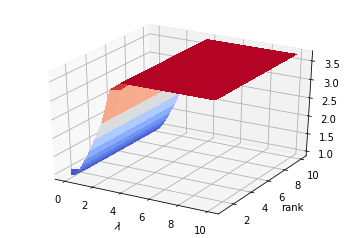

In [38]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.

# Plot the surface.
args = list(value_grid)
args.append(MSE_grid_)
surf = ax.plot_surface(*args, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('rank')
#ax.set_xscale('log')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [39]:
best_params

{'lambda_': 0.10826367338740546, 'rank': 10}

In [31]:
best_params

{'lambda_': 0.10000000000000001, 'rank': 2}

In [53]:
MSE_grid.shape
len(value_grids)
df = pd.DataFrame(value_grids, columns=['lambda', 'rank'])
df['MSE'] = MSE_grid

In [65]:
df[(df['lambda'] < 1.1) & (df['lambda'] > 0.9)]

,lambda,rank,MSE
19,0.923671,1,1.320015
49,0.923671,2,1.320016
79,0.923671,3,1.320015
109,0.923671,4,1.320016
139,0.923671,5,1.320015
169,0.923671,10,1.320015


In [63]:
df[df['lambda']==0.10826367338740546]

,lambda,rank,MSE
10,0.108264,1,0.954325
40,0.108264,2,0.933535
70,0.108264,3,0.926102
100,0.108264,4,0.924291
130,0.108264,5,0.922926
160,0.108264,10,0.922505


In [69]:
gain = (1.320015 - 0.922505)/1.320015
gain

0.3011405173426059

## Cross Validation

In [32]:
import numpy as np
import os
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

#u_data_file = os.path.join("ml-1m", "ratings.dat")
#ratings = sc.textFile(u_data_file).map(parse_data).cache()#.filter(lambda x: x is not None)

#ratings_train = ratings.filter(lambda x: x[3] < 8).map(lambda x: x[:-1])
#ratings_test = ratings.filter(lambda x: x[3] >= 8).map(lambda x: x[:-1])

#print("number of train points: %d" % ratings_train.count())
#print("number of test points: %d" % ratings_test.count())

n_folds = 10
MSE = np.zeros(n_folds)
for i, (ratings_train, ratings_test) in enumerate(kfold_cv_generator(ratings_sp, n_folds)):
    
    print ratings_train.count()
    # TODO: Remove timestamp column from the begining
    model = ALS.train(ratings_train.select(['UserID', 'MovieID', 'Rating']), rank = 10, iterations = 10)

    test_data = ratings_test.rdd.map(lambda r: (r[0], r[1]))
    predictions = model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
    p = predictions.collect()
    ratesAndPreds = ratings_test.rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    MSE[i] = (ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean())**.5

    print("Mean Squared Error = " + str(MSE))

89918


KeyboardInterrupt: 

In [33]:
ratings_sp.select(['UserID', 'MovieID', 'Rating'])

DataFrame[UserID: bigint, MovieID: bigint, Rating: double]

In [34]:
model = ALS.train(ratings_sp.select(['UserID', 'MovieID', 'Rating']), rank = 10, iterations = 20)

In [35]:
pf = model.productFeatures()
pf_coordinate = pf.map(lambda r: (r[0],  zip(range(len(r[1])), r[1]))).map(lambda r: r[0])

In [36]:
uf = model.userFeatures().collect()

In [37]:
from matplotlib import pyplot as plt

In [38]:
movie_index_list = [i[1] for i in model.recommendProducts(0, 10)]
[movie_index for movie_index_to_ID[movie_index]

SyntaxError: invalid syntax (<ipython-input-38-79f290f9d2d1>, line 2)

### Row-style to coordinate conversion:

In [39]:
"""
m = [
(0, (v00, v01, v02))
(2, (v20, v21, v22))
(5, (v50, v51, v52))
]

=>

[
(0, [(0, v00), (1, v01), (2, v02)])
(2, [(0, v20), (1, v21), (2, v22)])
(5, [(0, v50), (1, v51), (2, v52)])
]

=>

[
(0, 0, v00), (0, 1, v01), (0, 2, v02), 
(2, 0, v20), (2, 1, v21), (2, 2, v22), 

]
"""
def row_style_to_coordinate(m):
    x = m.map(lambda r: (r[0], zip(range(len(r[1])), r[1])))
    return x.flatMap(lambda r: [(r[0], i[0], i[1]) for i in r[1]])

In [40]:
def coordinate_to_sparse(m):
    row, col, data = np.array(m).T
    return csr_matrix((data, (row, col)))

In [41]:
pf_rdd = model.productFeatures()
uf_rdd = model.userFeatures()
user_features = row_style_to_coordinate(pf_rdd)
product_features = row_style_to_coordinate(uf_rdd)
print coordinate_to_sparse(user_features.collect()).todense().shape
print coordinate_to_sparse(product_features.collect()).todense().shape

(943, 10)
(1682, 10)


In [42]:
pf_sparse = coordinate_to_sparse(product_features.collect())

In [43]:
pf = np.array(pf_sparse.todense())

In [44]:
def array_norm(a):
    return ((a**2).dot(np.ones((a.shape[1], 1))))**0.5

In [45]:
pf.shape

(1682, 10)

In [46]:
from sklearn.preprocessing import normalize
pf_norm = normalize(pf, axis=1)

In [47]:
pf_norm = pf/((pf**2).dot(np.ones((pf_sparse.shape[1], 1))))**0.5

In [48]:
array_norm(pf_norm)

array([[ 1.],
       [ 1.],
       [ 1.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]])

In [49]:
pp_sim = np.dot(pf_norm, pf_norm.T)

In [50]:
pp_sim, movie_index_to_ID, movies

(array([[ 1.        ,  0.91312586,  0.38234589, ...,  0.60753014,
          0.86640718,  0.7694975 ],
        [ 0.91312586,  1.        ,  0.46959098, ...,  0.4061653 ,
          0.65946043,  0.62129672],
        [ 0.38234589,  0.46959098,  1.        , ...,  0.4069768 ,
          0.34864356,  0.55575903],
        ..., 
        [ 0.60753014,  0.4061653 ,  0.4069768 , ...,  1.        ,
          0.60386915,  0.81192854],
        [ 0.86640718,  0.65946043,  0.34864356, ...,  0.60386915,
          1.        ,  0.73170757],
        [ 0.7694975 ,  0.62129672,  0.55575903, ...,  0.81192854,
          0.73170757,  1.        ]]),
 {0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 11,
  11: 12,
  12: 13,
  13: 14,
  14: 15,
  15: 16,
  16: 17,
  17: 18,
  18: 19,
  19: 20,
  20: 21,
  21: 22,
  22: 23,
  23: 24,
  24: 25,
  25: 26,
  26: 27,
  27: 28,
  28: 29,
  29: 30,
  30: 31,
  31: 32,
  32: 33,
  33: 34,
  34: 35,
  35: 36,
  36: 37,
  37: 38,
  38: 39,
 

In [51]:
np.save('movie_index_to_ID', movie_index_to_ID)

In [57]:
movies.to_pickle('movies_df.pkl')

In [62]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [63]:
save_obj(movie_index_to_ID, 'movie_index_to_ID')

In [58]:
!cp movies_df.pkl web/django_proj/data/

In [118]:
np.argsort(pp_sim[0, :])

array([1335, 1597,  986, ...,  203,   94,    0])

In [43]:
recom_movie_index = np.argsort(pp_sim[0, :])[::-1][:10]

In [44]:
recom_movie_index

array([  0,  94, 193, 209, 417,  27,  70, 658,  63,  98])

In [150]:
recom_movie_index

array([  0,  94, 203, 209, 676, 598, 710, 193, 434, 658])

In [45]:
movies[(movies.Horror == 1) & (movies['Sci-Fi'] == 1)].head()

,MovieID,movie-title,release-date,video-release-date,IMDb-URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
83,84,Robert A. Heinlein's The Puppet Masters (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Robert%20A.%2...,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
100,101,Heavy Metal (1981),08-Mar-1981,NaN,http://us.imdb.com/M/title-exact?Heavy%20Metal...,0,1,1,1,0,...,0,0,1,0,0,0,1,0,0,0
182,183,Alien (1979),01-Jan-1979,NaN,http://us.imdb.com/M/title-exact?Alien%20(1979),0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
183,184,Army of Darkness (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Army%20of%20D...,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,0
342,343,Alien: Resurrection (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Alien%3A+Resu...,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [46]:
pp_sim[182, 0]

0.80193257728903866

In [97]:
movies.loc[0, 'IMDb-URL']

'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)'

In [47]:
movies.head()

,MovieID,movie-title,release-date,video-release-date,IMDb-URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [48]:
[movies[movies.MovieID == movie_index_to_ID[i]]['movie-title'].tolist()[0] for i in recom_movie_index]

['Toy Story (1995)',
 'Aladdin (1992)',
 'Sting, The (1973)',
 'Indiana Jones and the Last Crusade (1989)',
 'Cinderella (1950)',
 'Apollo 13 (1995)',
 'Lion King, The (1994)',
 'Arsenic and Old Lace (1944)',
 'Shawshank Redemption, The (1994)',
 'Snow White and the Seven Dwarfs (1937)']

In [152]:
recom_movie_index

array([  0,  94, 203, 209, 676, 598, 710, 193, 434, 658])

In [231]:
recom_movie_index

array([1642, 1462, 1119, 1153, 1285])

In [42]:
#help(pd.DataFrame({'MovieID':[movie_index_to_ID[i] for i in recom_movie_index]}).join)

In [43]:
(pd.DataFrame({'MovieID':[movie_index_to_ID[i] for i in recom_movie_index]})).join

<bound method DataFrame.join of    MovieID
0      718
1      361
2     1643
3     1375
4     1218>

In [50]:
pd.merge(pd.DataFrame({'MovieID':[movie_index_to_ID[i] for i in recom_movie_index]}), movies, how='inner', on='MovieID', suffixes=('_x', '_y'))

,MovieID,movie-title,release-date,video-release-date,IMDb-URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,95,Aladdin (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Aladdin%20(1992),0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
2,194,"Sting, The (1973)",01-Jan-1973,NaN,"http://us.imdb.com/M/title-exact?Sting,%20The%...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,210,Indiana Jones and the Last Crusade (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?Indiana%20Jon...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,418,Cinderella (1950),01-Jan-1950,NaN,http://us.imdb.com/M/title-exact?Cinderella%20...,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
5,28,Apollo 13 (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Apollo%2013%2...,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,71,"Lion King, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Lion%20King,%...",0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
7,659,Arsenic and Old Lace (1944),01-Jan-1944,NaN,http://us.imdb.com/M/title-exact?Arsenic%20and...,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
8,64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,99,Snow White and the Seven Dwarfs (1937),01-Jan-1937,NaN,http://us.imdb.com/M/title-exact?Snow%20White%...,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0


In [46]:
pd.DataFrame({'MovieID':[movie_index_to_ID[i] for i in recom_movie_index]}).join

<bound method DataFrame.join of    MovieID
0      718
1      361
2     1643
3     1375
4     1218>

In [154]:
[movies['movie-title'].loc[movie_index_to_ID[i]] for i in recom_movie_index]

['GoldenEye (1995)',
 'Terminator 2: Judgment Day (1991)',
 'Patton (1970)',
 'M*A*S*H (1970)',
 'Volcano (1997)',
 "Daniel Defoe's Robinson Crusoe (1996)",
 'Tin Men (1987)',
 'Terminator, The (1984)',
 'American Werewolf in London, An (1981)',
 'Fried Green Tomatoes (1991)']

In [156]:
movies.loc[recom_movie_index]

,MovieID,movie-title,release-date,video-release-date,IMDb-URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
94,95,Aladdin (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Aladdin%20(1992),0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
203,204,Back to the Future (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Back%20to%20t...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
209,210,Indiana Jones and the Last Crusade (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?Indiana%20Jon...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
676,677,Fire on the Mountain (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Fire%20on%20t...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,599,Police Story 4: Project S (Chao ji ji hua) (1993),16-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Project%20S%2...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
710,711,"Substance of Fire, The (1996)",06-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Substance%20o...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193,194,"Sting, The (1973)",01-Jan-1973,NaN,"http://us.imdb.com/M/title-exact?Sting,%20The%...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
434,435,Butch Cassidy and the Sundance Kid (1969),01-Jan-1969,NaN,http://us.imdb.com/M/title-exact?Butch%20Cassi...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
658,659,Arsenic and Old Lace (1944),01-Jan-1944,NaN,http://us.imdb.com/M/title-exact?Arsenic%20and...,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [51]:
np.save('pp_sim', pp_sim)

In [52]:
!ls -lh pp_sim.npy

-rw-r--r-- 1 amir amir 22M Jun 20 22:57 pp_sim.npy


In [53]:
np.load('pp_sim.npy')

array([[ 1.        ,  0.85107265,  0.54099519, ...,  0.49139953,
         0.88329808,  0.76449662],
       [ 0.85107265,  1.        ,  0.53455897, ...,  0.54254158,
         0.72213454,  0.6871966 ],
       [ 0.54099519,  0.53455897,  1.        , ...,  0.83634423,
         0.40177111,  0.65079745],
       ..., 
       [ 0.49139953,  0.54254158,  0.83634423, ...,  1.        ,
         0.38850745,  0.71621046],
       [ 0.88329808,  0.72213454,  0.40177111, ...,  0.38850745,
         1.        ,  0.73907372],
       [ 0.76449662,  0.6871966 ,  0.65079745, ...,  0.71621046,
         0.73907372,  1.        ]])

In [190]:
def get_movie_image(url):
    return Image(url=get_poster(url, base_url, api_key))

In [59]:
get_poster(movie_list[1], base_url, api_key)

u'http://image.tmdb.org/t/p/w185/1oqfg2IBGNFAFylDK56NXo558y2.jpg'

In [276]:
s = ''
for url in movie_list:
    s += '<img src="%s" >' % get_poster_imdb(url)

In [277]:
s

'<img src="https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_SY500_SX335_AL_.jpg" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BNTI4ODQ1MzAzNV5BMl5BanBnXkFtZTgwMzU4NzMxMDE@._V1_SY250_CR0,0,187,250_AL_.jpg" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BZmU0M2Y1OGUtZjIxNi00ZjBkLTg1MjgtOWIyNThiZWIwYjRiXkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_SY500_CR0,0,321,500_AL_.jpg" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BMjNkMzc2N2QtNjVlNS00ZTk5LTg0MTgtODY2MDAwNTMwZjBjXkEyXkFqcGdeQXVyNDk3NzU2MTQ@._V1_SY500_CR0,0,339,500_AL_.jpg" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BMTI1OTk5MjQyM15BMl5BanBnXkFtZTcwOTM5NzEyMQ@@._V1_SX165_CR0,0,165,237_AL_.jpg" ><img src="" ><img src="" ><img src="" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BMTkyMTM2NDk5Nl5BMl5BanBnXkFtZTgwNzY1NzEyMDE@._V1_SY500_CR0,0,337,500_AL_.jpg" ><img src="https://im

In [160]:
s

u'<img src="http://image.tmdb.org/t/p/w185/uMZqKhT4YA6mqo2yczoznv7IDmv.jpg" ><img src="http://image.tmdb.org/t/p/w185/qsHpmqekgeQKMKL8PWnFsrXTXGs.jpg" ><img src="http://image.tmdb.org/t/p/w185/pTpxQB1N0waaSc3OSn0e9oc8kx9.jpg" ><img src="http://image.tmdb.org/t/p/w185/g8qWglC2XXCIN8P51eCljFvCNNJ.jpg" ><img src="" ><img src="http://image.tmdb.org/t/p/w185/7pgS6qYWtSiJpEJW3YQJqD6EVRG.jpg" ><img src="http://image.tmdb.org/t/p/w185/uXMTgqPIJwLnzcDdIvvD5OUqX8x.jpg" ><img src="http://image.tmdb.org/t/p/w185/mQaM8fDQdFWwCTFp0TZG8fChlZ5.jpg" ><img src="http://image.tmdb.org/t/p/w185/jQH0mTzQ1gQ56H8a0z52WreiEok.jpg" ><img src="http://image.tmdb.org/t/p/w185/jfNhx7ATKNvblvbb7wsfm4YpPaR.jpg" >'

<img src="http://image.tmdb.org/t/p/w185/uMZqKhT4YA6mqo2yczoznv7IDmv.jpg" ><img src="http://image.tmdb.org/t/p/w185/qsHpmqekgeQKMKL8PWnFsrXTXGs.jpg" ><img src="http://image.tmdb.org/t/p/w185/pTpxQB1N0waaSc3OSn0e9oc8kx9.jpg" ><img src="http://image.tmdb.org/t/p/w185/g8qWglC2XXCIN8P51eCljFvCNNJ.jpg" ><img src="" ><img src="http://image.tmdb.org/t/p/w185/7pgS6qYWtSiJpEJW3YQJqD6EVRG.jpg" ><img src="http://image.tmdb.org/t/p/w185/uXMTgqPIJwLnzcDdIvvD5OUqX8x.jpg" ><img src="http://image.tmdb.org/t/p/w185/mQaM8fDQdFWwCTFp0TZG8fChlZ5.jpg" ><img src="http://image.tmdb.org/t/p/w185/jQH0mTzQ1gQ56H8a0z52WreiEok.jpg" ><img src="http://image.tmdb.org/t/p/w185/jfNhx7ATKNvblvbb7wsfm4YpPaR.jpg" >'


'<img src="https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_SY500_SX335_AL_.jpg" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BNTI4ODQ1MzAzNV5BMl5BanBnXkFtZTgwMzU4NzMxMDE@._V1_SY250_CR0,0,187,250_AL_.jpg" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BZmU0M2Y1OGUtZjIxNi00ZjBkLTg1MjgtOWIyNThiZWIwYjRiXkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_SY500_CR0,0,321,500_AL_.jpg" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BMjNkMzc2N2QtNjVlNS00ZTk5LTg0MTgtODY2MDAwNTMwZjBjXkEyXkFqcGdeQXVyNDk3NzU2MTQ@._V1_SY500_CR0,0,339,500_AL_.jpg" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BMTI1OTk5MjQyM15BMl5BanBnXkFtZTcwOTM5NzEyMQ@@._V1_SX165_CR0,0,165,237_AL_.jpg" ><img src="" ><img src="" ><img src="" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BMTkyMTM2NDk5Nl5BMl5BanBnXkFtZTgwNzY1NzEyMDE@._V1_SY500_CR0,0,337,500_AL_.jpg" ><img src="https://images-na.ssl-images-amazon.com/images/M/MV5BZDVlNTBjMjctNjAzNS00ZGJhLTg2NzMtNzIwYTIzYTBiMDkyXkEyXkFqcGdeQXVyNTA4NzY1MzY@._V1_SY500_CR0,0,332,500_AL_.jpg" >'


### Get Movie Posters

In [56]:
import requests
resp = requests.get('http://www.imdb.com/title/tt0114709/?ref_=nv_sr_1')
from bs4 import BeautifulSoup
bs = BeautifulSoup(resp.content, "lxml")

In [57]:
url

NameError: name 'url' is not defined

In [58]:
base_url = 'http://www.imdb.com/'
url = base_url + bs.find("div", class_="poster").a['href']
resp = requests.get(url)
bs = BeautifulSoup(resp.content, 'lxml')

In [59]:
#<div class="pswp__zoom-wrap" style="transform: translate3d(727px, 0px, 0px) scale(1);"><img class="pswp__img pswp__img--placeholder" src="https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_SY500_SX335_AL_.jpg" style="width: 594px; height: 887px; display: none;"><img class="pswp__img" src="https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_SY1000_SX670_AL_.jpg" style="display: block; width: 291px; height: 435px;"></div>
image_url = bs.find('meta', itemprop='image')['content']

In [62]:
def get_poster_imdb(url):
    try:
        resp = requests.get(url)
        bs = BeautifulSoup(resp.content, "lxml")
        base_url = 'http://www.imdb.com/'
        url = base_url + bs.find("div", class_="poster").a['href']
        resp = requests.get(url)
        bs = BeautifulSoup(resp.content, 'lxml')
        return bs.find('meta', itemprop='image')['content']
    except:
        return ""

In [63]:
Image(url=image_url)

NameError: name 'Image' is not defined

In [111]:
a = movies.iloc[5, :]['movie-title']
search_url = 'http://www.imdb.com/xml/find?json=1&nr=1&tt=on&q=%s' % urllib.quote_plus(a)
res = requests.get(search_url)

In [112]:
a

'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)'

In [113]:
import urllib
urllib.quote_plus(a)

'Shanghai+Triad+%28Yao+a+yao+yao+dao+waipo+qiao%29+%281995%29'

In [114]:
search_url = 'http://www.imdb.com/xml/find?json=1&nr=1&tt=on&q=%s' % urllib.quote_plus(a)
res = requests.get(search_url)

In [116]:
search_url

'http://www.imdb.com/xml/find?json=1&nr=1&tt=on&q=Shanghai+Triad+%28Yao+a+yao+yao+dao+waipo+qiao%29+%281995%29'

In [102]:
import json
res_json = json.loads(res.content)

In [117]:
res_json.keys()

[u'title_substring', u'title_popular', u'title_exact']

In [106]:
res_json['title_exact'][0]['id']

u'tt2236686'

In [64]:
import requests
import json

response = requests.get('http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)')
print response.url.split('/')[-2]

tt0114709


In [65]:
# Build function to query themoviedb.org's API

# Get base url filepath structure. w185 corresponds to size of movie poster.
api_key = '2554c0fd4b04956e926253a3337c3252'
headers = {'Accept': 'application/json'}
payload = {'api_key': api_key} 
response = requests.get("http://api.themoviedb.org/3/configuration",\
                        params=payload,\
                        headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdb_url, base_url, api_key):
    # Get IMDB movie ID
    response = requests.get(imdb_url)
    movie_id = response.url.split('/')[-2]
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': api_key} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        # IMDB movie ID is sometimes no good. Need to get correct one.
        movie_title = imdb_url.split('?')[-1].split('(')[0]
        payload['query'] = movie_title
        response = requests.get('http://api.themoviedb.org/3/search/movie',\
                                params=payload,\
                                headers=headers)
        try:
            movie_id = json.loads(response.text)['results'][0]['id']
            payload.pop('query', None)
            movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'\
                        .format(movie_id)
            response = requests.get(movie_url, params=payload, headers=headers)
            file_path = json.loads(response.text)['posters'][0]['file_path']
        except:
            # Sometimes the url just doesn't work.
            # Return '' so that it does not mess up Image()
            return ''
        
    return base_url + file_path

In [66]:
get_poster(toy_story, base_url, api_key)

NameError: name 'toy_story' is not defined

In [57]:
from IPython.display import Image
from IPython.display import display

toy_story = 'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)'
Image(url=get_poster(toy_story, base_url, api_key))

<img src="http://image.tmdb.org/t/p/w185/uMZqKhT4YA6mqo2yczoznv7IDmv.jpg">

In [162]:
product_features_T = product_features.map(lambda r: (r[1], r[0], r[2]))
pp_sim_rdd = matrix_multiply(product_features, product_features_T)
pp_sim = pp_sim_rdd.collect()

KeyboardInterrupt: 

In [1]:
def matrix_multiply(x, y):
    def left_mapper(r):
        i, j, v = r
        return j, (i, v)
    def right_mapper(r):
        j, k, w = r
        return j, (k, w)
    def product_mapper(r):
        _, ((i, v), (k, w)) = r
        return (i, k), v * w
    
    x = x.map(left_mapper)
    y = y.map(right_mapper)
    
    return x.join(y).map(product_mapper).reduceByKey(lambda x, y: x + y).map(lambda r: r[0][0], r[0][1], r[1])

In [21]:
l = [(0, 0, 3.0), (2, 0, -5.0), (3, 2, 1.0),
   (4, 1, 6.0), (6, 2, 2.0), (8, 1, 4.0)]
row = [i[0] for i in l]
col = [i[1] for i in l]
data = [i[2] for i in l]

row, col, data = np.array(l).T
from scipy.sparse import csr_matrix
m1 = csr_matrix((data, (row, col)))

In [22]:
m1.todense()

matrix([[ 3.,  0.,  0.],
        [ 0.,  0.,  0.],
        [-5.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  6.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  2.],
        [ 0.,  0.,  0.],
        [ 0.,  4.,  0.]])

In [13]:
m1.T

<3x9 sparse matrix of type '<type 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Column format>

In [20]:
import numpy as np
np.dot(m1.todense(), m1.todense().T)

matrix([[  9.,   0., -15.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [-15.,   0.,  25.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  36.,   0.,   0.,   0.,  24.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   2.,   0.,   0.,   4.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  24.,   0.,   0.,   0.,  16.]])

In [4]:
mat = sc.parallelize([
   (0, 0, 3.0), (2, 0, -5.0), (3, 2, 1.0),
   (4, 1, 6.0), (6, 2, 2.0), (8, 1, 4.0)]
)

In [17]:
mat_t = sc.parallelize([(j, i, v) for i, j, v in l])

In [26]:
matrix_multiply(mat, mat_t).collect()

[((2, 0), -15.0),
 ((6, 3), 2.0),
 ((0, 0), 9.0),
 ((4, 4), 36.0),
 ((8, 8), 16.0),
 ((0, 2), -15.0),
 ((3, 3), 1.0),
 ((4, 8), 24.0),
 ((8, 4), 24.0),
 ((6, 6), 4.0),
 ((2, 2), 25.0),
 ((3, 6), 2.0)]

In [ ]:
number of unique movies: 3883
number of users: 6040

In [68]:
set(x) == set(range(6040))

True

In [69]:
set(y) == set(range(3706))

True

In [66]:
x = [i[0] for i in pf]

In [67]:
y = [i[0] for i in uf]

In [ ]:
pd.DataFrame(x).describe()

In [ ]:
max(sorted(y))

In [ ]:
pd.DataFrame(y).describe()

In [ ]:
plt.plot(sorted(x), '.')
plt.show()

In [ ]:
dir(model)

In [ ]:
np.mean([i[1] for i in p])

In [ ]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



lr = LogisticRegression(maxIter=10)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, np.logspace(-2, 2, 5)) \
    .build()

cnt = 0

class Evaluator:
    def evaluate(self, dataset):
        global cnt
        cnt += 1
        print dataset.count()
        print cnt
        #print dataset['features'].collect()
        #print dataset['label']
        print
        return 1
    
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          #evaluator=BinaryClassificationEvaluator(),
                          evaluator=Evaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

In [ ]:
import os
spark_home = os.environ['SPARK_HOME']
training = spark.read.format("libsvm").load(os.path.join(spark_home, "data/mllib/sample_libsvm_data.txt"))

In [ ]:
training